In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 7 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]


# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)

# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


# Download Embeddings

In [ ]:
import os
import tqdm
import requests
import zipfile

URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'

def fetch_data(url=URL,target_file='/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/embeddings/glove.zip', delete_zip=False):
    # if dataset exists exit
    if os.path.isfile(target_file):
        print('datasets already downloaded')
        return

        #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall(path='/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/embeddings')
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)

fetch_data()

datasets already downloaded


# Imports

In [9]:
import os
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from sklearn import preprocessing
import nlpaug.augment.char as nac


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Set Variables

In [10]:
MODEL_NAME1 = 'best_model_scratch.h5'
MODEL_NAME2 = 'best_model_pretrained.h5'
model_path = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/models'

model_path_scratch = os.path.join(model_path, MODEL_NAME1)
model_path_pretrained = os.path.join(model_path, MODEL_NAME2)

intents_path = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/data/intents'

# inference model variables
inference_load_intents_from = os.path.join(intents_path, 'intents_job_intents.json')

# holds all classes and patterns
all_tags = []
all_patterns = []
words = []
tags = []
classes = []
documents = []
label_encoded_Y = []
x_tr_seq = []
x_val_seq = []
y_tr = []
y_val = []
ignore_words = ['?', '!']

# Load JSON

In [11]:
data_file = open(inference_load_intents_from, encoding='cp1252').read()
intents = json.loads(data_file)

## Read in patterns and tags

Patterns are the user input (i.e., 'Hi,' 'How are you?').

Nothing is tokenized here.

In [12]:
# print classes
aug = nac.KeyboardAug()
for intent in intents['intents']:
    all_patterns.extend(intent['patterns'])
    for pattern in intent['patterns']:
        all_tags.append(intent['tag'])
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))

        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))

print(f'{len(documents)} documents')
print(f'{len(classes)} classes: {classes}')
print(f'{len(words)} unique lemmatized words {words}')
print('---------------------------------')
print(f'All tags: {all_tags}')
print(f'All patterns: {all_patterns}')

151 documents
8 classes: ['Human', 'Name', 'Number', 'Positive Feedback', 'Product Return', 'Track Package', 'farewell statement', 'greeting']
167 unique lemmatized words ["'m", "'s", ',', '.', '0987342341987089', '0987432387459872', '0987532987345892', '0987643213489032', '1234567887654321', '2342139809878923', '2349870987098234', '3234709172344231', '3241234213489708', '3842701829374123', '4320918723412234', '5342103987098753', '5780523412341234', '6789032143241234', '7389238745239873', '7609870982731453', '7890987212345213', '8398708230982374', '8534234323432340', '8907908734212343', '9873201234213384', 'a', 'adieu', 'adios', 'adore', 'all', 'am', 'amazing', 'an', 'appreciate', 'are', 'around', 'au', 'back', 'beneficial', 'best', 'bonjour', 'bot', 'broken', 'btw', 'by', 'bye', 'bye-bye', 'call', 'can', 'chat', 'chatbot', 'chatbots', 'chatting', 'cheerio', 'computer', 'customer', 'day', 'device', 'do', 'doe', 'equipment', 'excellent', 'favorite', 'find', 'fix', 'fixed', 'for', 'get',

## Encode Tags



### Fit

In [ ]:
# create label encoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# fit on all tags from JSON file
le.fit(all_tags)
print(f'Number of classes: {len(list(le.classes_))}')

Number of classes: 8


### Transform

In [ ]:
label_encoded_Y = le.transform(all_tags)
print(f'Label_encoded_Y: {label_encoded_Y}')
print(f'Label_encoded_Y bincount: {np.bincount(label_encoded_Y)}')

Label_encoded_Y: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]
Label_encoded_Y bincount: [ 9 18 21 26 31  8 19 19]


## Create x_all, y_all

In [ ]:
X_all = np.asarray(all_patterns)
y_all = np.asarray(label_encoded_Y)
print(f'X all shape: {X_all.shape}')
print(f'Y all shape: {y_all.shape}')
print(f'y_all: {y_all}')

X all shape: (151,)
Y all shape: (151,)
y_all: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


# Tokenize

# Save tokenization file

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_all))
print(tokenizer.word_index)
with open('/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/data/intents/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_all_seq = tokenizer.texts_to_sequences(X_all)
print(X_all_seq)

{'you': 1, 'i': 2, 'are': 3, 'my': 4, 'a': 5, 'your': 6, 'is': 7, 'to': 8, 'product': 9, 'need': 10, 'service': 11, 'name': 12, 'return': 13, 'want': 14, 'what': 15, 'do': 16, 'me': 17, 'have': 18, 'so': 19, 'help': 20, 'am': 21, 'not': 22, 'work': 23, 'package': 24, 'very': 25, 'where': 26, 'bye': 27, 'later': 28, 'with': 29, 'broken': 30, 'refund': 31, 'computer': 32, 'this': 33, 'track': 34, 'good': 35, "what's": 36, 'see': 37, 'now': 38, 'device': 39, 'money': 40, 'back': 41, 'does': 42, 'an': 43, 'love': 44, 'beneficial': 45, 'or': 46, 'person': 47, 'hi': 48, 'howdy': 49, 'hello': 50, 'how': 51, 'can': 52, 'go': 53, 'leaving': 54, 'fix': 55, 'it': 56, 'helpful': 57, 'favorite': 58, 'appreciate': 59, 'the': 60, 'great': 61, 'find': 62, 'invaluable': 63, 'kind': 64, 'excellent': 65, 'amazing': 66, 'whom': 67, 'speaking': 68, 'please': 69, 'tell': 70, 'by': 71, 'btw': 72, 'human': 73, 'real': 74, 'bot': 75, 'machine': 76, 'shipment': 77, 'greetings': 78, 'bonjour': 79, 'day': 80, 'mo

### Pad

In [ ]:
# padding to prepare sequences of same length
X_all_seq = pad_sequences(X_all_seq, maxlen=25)
print(X_all_seq)
#type is now a numpy.ndarray
print(type(X_all_seq))
print(f'Shape (X_all): {X_all_seq.shape}')

[[  0   0   0 ...   0   0  78]
 [  0   0   0 ...   0   0  48]
 [  0   0   0 ...   0   0  49]
 ...
 [  0   0   0 ...   0   0 164]
 [  0   0   0 ...   0   0 165]
 [  0   0   0 ...   0   0 166]]
<class 'numpy.ndarray'>
Shape (X_all): (151, 25)


# Vocab Size

In [ ]:
size_of_vocabulary = len(tokenizer.word_index) + 1 #+1 for padding
print(tokenizer.word_index)
print(f'Size of vocab: {size_of_vocabulary}')

{'you': 1, 'i': 2, 'are': 3, 'my': 4, 'a': 5, 'your': 6, 'is': 7, 'to': 8, 'product': 9, 'need': 10, 'service': 11, 'name': 12, 'return': 13, 'want': 14, 'what': 15, 'do': 16, 'me': 17, 'have': 18, 'so': 19, 'help': 20, 'am': 21, 'not': 22, 'work': 23, 'package': 24, 'very': 25, 'where': 26, 'bye': 27, 'later': 28, 'with': 29, 'broken': 30, 'refund': 31, 'computer': 32, 'this': 33, 'track': 34, 'good': 35, "what's": 36, 'see': 37, 'now': 38, 'device': 39, 'money': 40, 'back': 41, 'does': 42, 'an': 43, 'love': 44, 'beneficial': 45, 'or': 46, 'person': 47, 'hi': 48, 'howdy': 49, 'hello': 50, 'how': 51, 'can': 52, 'go': 53, 'leaving': 54, 'fix': 55, 'it': 56, 'helpful': 57, 'favorite': 58, 'appreciate': 59, 'the': 60, 'great': 61, 'find': 62, 'invaluable': 63, 'kind': 64, 'excellent': 65, 'amazing': 66, 'whom': 67, 'speaking': 68, 'please': 69, 'tell': 70, 'by': 71, 'btw': 72, 'human': 73, 'real': 74, 'bot': 75, 'machine': 76, 'shipment': 77, 'greetings': 78, 'bonjour': 79, 'day': 80, 'mo

# Load the Whole Embedding into Memory

## DOES NOT NEED TO BE RE-RUN!

In [ ]:
# load the whole embedding into memory
path_to_glove_file = '/content/drive/MyDrive/Colab Notebooks/chatbot-flask-simple/embeddings/glove.840B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  


Found 2195884 word vectors.


# Create the weight matrix

In [ ]:
# create a weight matrix for words in training docs
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))
hits = 0
misses = 0
missedWords = []
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and embedding_vector.shape[0] != 0:       
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missedWords.append(word)
print(f'Converted {hits} words ({misses} misses)')
print(missedWords)       


Converted 137 words (29 misses)
['is', 'to', "what's", 'or', 'by', "i'm", 'impecabble', "where's", '1234567887654321', '8534234323432340', '0987643213489032', '0987532987345892', '2349870987098234', '0987432387459872', '0987342341987089', '8398708230982374', '8907908734212343', '3234709172344231', '3842701829374123', '9873201234213384', '7389238745239873', '7890987212345213', '3241234213489708', '2342139809878923', '5342103987098753', '5780523412341234', '7609870982731453', '6789032143241234', '4320918723412234']


# Write Pickle and classes to file

In [ ]:
pickle.dump(words,open(os.path.join(intents_path, 'intents_words.pkl'),'wb'))
pickle.dump(classes,open(os.path.join(intents_path, 'intents_classes.pkl'),'wb'))
training = []
output_empty = [0] * len(classes)
for seq, doc in zip(X_all_seq, documents):
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([seq, output_row])

print(training)

[[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 78], dtype=int32), [0, 0, 0, 0, 0, 0, 0, 1]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 48], dtype=int32), [0, 0, 0, 0, 0, 0, 0, 1]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 49], dtype=int32), [0, 0, 0, 0, 0, 0, 0, 1]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 79], dtype=int32), [0, 0, 0, 0, 0, 0, 0, 1]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 35, 80], dtype=int32), [0, 0, 0, 0, 0, 0, 0, 1]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 35, 81], dtype=int32), [0, 0, 0, 0, 0, 0, 0, 1]], [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

In [ ]:

import random
random.seed(0)
random.shuffle(training)
training = np.array(training)
X_train_all = list(training[:,0])
y_train_all = list(training[:,1])
print(len(X_train_all))
print(len(y_train_all))

151
151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


# Build Model

## Create model bag of words



In [ ]:
# init training data
training_bow = []
output_empty = [0] * len(classes)
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training_bow.append([bag, output_row])

random.shuffle(training_bow)
training_bow = np.array(training_bow)
# create train and test lists.  X - patterns, y - intents
X_train_bag = list(training_bow[:,0])
y_train_bag = list(training_bow[:,1])
print('Training data created')
print(f'X train: {X_train_bag}')
print(f'y train: {y_train_bag}')


Training data created
X train: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:

def create_model_bag():

    model = Sequential()
    model.add(Dense(128, input_shape=(len(X_train_bag[0]),), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(y_train_bag[0]), activation='softmax'))

    # Compile model.  Stochastic gradient descent with Nesterov accelerated
    # gradient gives good
    # results for this model
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())

    return model

# Create model scratch

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
from keras.callbacks import *
from keras.initializers import Constant

def create_model_scratch():
    model = Sequential()
    #embedding layer
    model.add(Embedding(size_of_vocabulary,300,
                        input_length=25,
                        trainable=True))
    #lstm layer
    model.add(LSTM(128,return_sequences=True,dropout=0.2))

    #Global Maxpooling
    model.add(GlobalMaxPooling1D())

    #Dense Layer
    model.add(Dense(64,activation='relu'))
    model.add(Dense(len(y_train_all[0]),activation='softmax'))

    #Add loss function, metrics, optimizer
    # Compile model.  Stochastic gradient descent with Nesterov accelerated
    # gradient gives good
    # results for this model
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    #addingcallbacks
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
    #mc = ModelCheckpoint(model_path_scratch, monitor='val_accuracy', mode='max', 
                         #save_best_only=True, verbose=1)
    
    print(model.summary())

    return model

    


## Create pretrained model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
from keras.callbacks import *
from keras.initializers import Constant

def create_model_pretrained():
    model = Sequential()
    #embedding layer
    model.add(Embedding(size_of_vocabulary,300,
                        input_length=25,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=True))
    #lstm layer
    model.add(LSTM(128,return_sequences=True,dropout=0.2))

    #Global Maxpooling
    model.add(GlobalMaxPooling1D())

    #Dense Layer
    model.add(Dense(64,activation='relu'))
    model.add(Dense(len(y_train_all[0]),activation='softmax'))

    #Add loss function, metrics, optimizer
    # Compile model.  Stochastic gradient descent with Nesterov accelerated
    # gradient gives good
    # results for this model
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    #addingcallbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
    mc = ModelCheckpoint(model_path_pretrained, monitor='val_accuracy', mode='max', 
                         save_best_only=True, verbose=2)
    
    print(model.summary())

    return model

    


In [ ]:
np.argmax(y_train_all, axis=1).shape

(151,)

# GRAPH

In [ ]:
print(np.argmax(y_train_all, axis=1))

[6 4 4 3 3 7 4 2 2 6 1 0 6 2 1 1 0 4 6 5 4 1 0 7 5 6 3 4 7 6 2 4 6 1 3 1 2
 2 1 3 3 7 0 5 0 6 4 4 4 7 1 4 4 7 7 3 7 3 4 7 4 4 7 6 2 3 3 4 1 0 6 3 5 3
 2 1 7 2 1 4 7 4 4 2 2 1 4 3 2 6 6 2 2 7 1 4 3 6 4 4 5 7 3 3 1 3 4 2 3 7 7
 0 2 7 6 2 1 4 4 3 6 0 3 3 4 2 4 2 0 3 7 6 3 6 4 6 2 3 6 5 4 3 5 3 1 5 2 4
 7 1 1]


WordEmbeddings (pre-trained) <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f66b28ea150>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.7min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.8804166666666667
WordEmbeddings (from scratch) <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f669f3ef650>


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.4min remaining: 10.3min


0.5816666666666668


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.3s remaining:   28.8s


label: ('BOW 0.808', 'WordEmbeddings (from scratch) 0.582', 'WordEmbeddings (pre-trained) 0.880'), handle: (<matplotlib.lines.Line2D object at 0x7f684f6bd790>, <matplotlib.lines.Line2D object at 0x7f684f6e7fd0>, <matplotlib.lines.Line2D object at 0x7f684f68a910>)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.8s finished


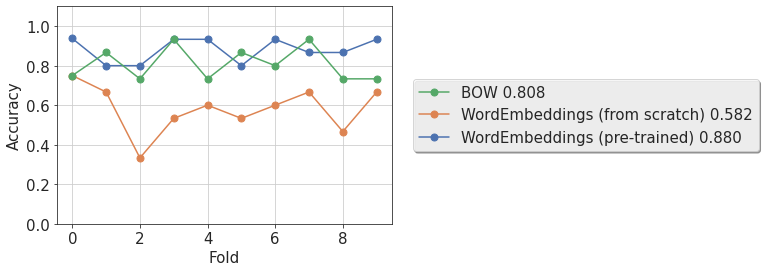

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

pretrained = KerasClassifier(build_fn=create_model_pretrained, epochs=300,
                             batch_size=5, verbose=2)
scratch = KerasClassifier(build_fn=create_model_scratch, epochs=300, 
                          batch_size=5, verbose=2)
bag_of_words = KerasClassifier(build_fn=create_model_bag, epochs=300, 
                               batch_size=5, verbose=2)
classifiers = {'WordEmbeddings (pre-trained)': pretrained,
               'WordEmbeddings (from scratch)': scratch}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fig, ax = plt.subplots()
for name, model in classifiers.items():
    print(name, model)
    cv_scores = cross_val_score(model,
                                np.array(X_train_all), 
                                np.argmax(y_train_all, axis=1),
                                cv=kfold,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=2)
    print(cv_scores.mean())
    my_lbl = f'{name} {cv_scores.mean():.3f}'
    ax.plot(cv_scores, '-o', label=my_lbl) 

cv_scores = cross_val_score(bag_of_words,
                           np.array(X_train_bag),
                           np.argmax(y_train_bag, axis=1),
                           cv=kfold,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

my_lbl = f'BOW {cv_scores.mean():.3f}'
ax.plot(cv_scores, '-o', label=my_lbl) 
ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by accuracy
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))   
print(f'label: {labels}, handle: {handles}')

ax.legend(handles, labels, ncol=1, bbox_to_anchor=(1.04,.5),loc='center left')

plt.show() 

In [ ]:
pretrained.fit(np.array(X_train_all), np.argmax(y_train_all, axis=1))
pretrained.model.save(os.path.join(intents_path, 'pretrained_embeddings.h5'))
bag_of_words.fit(np.array(X_train_bag),np.argmax(y_train_bag, axis=1))
bag_of_words.model.save(os.path.join(intents_path, 'BOW_embeddings.h5'))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           50100     
_________________________________________________________________
lstm (LSTM)                  (None, 25, 128)           219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 278,524
Trainable params: 278,524
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
31/31 - 2s - loss: 1.9688 - accuracy: 0.2450
Epoch 2/300
31/31 - 1s - loss: 1.7054 - accuracy: 0.47